In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pdf2image
import easyocr
import pandas as pd
%matplotlib inline 


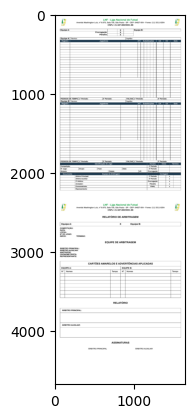

In [2]:
basepdf_path = 'images/input/BASE-LNF.pdf'
images = pdf2image.convert_from_path(basepdf_path)
#merge all pages into one
base = np.vstack(images)
plt.imshow(base)


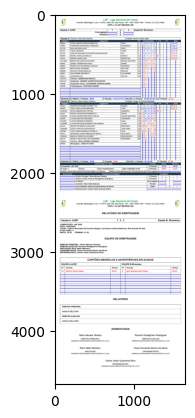

In [3]:
sum_path = 'images/input/Sumula1-LNF.pdf'
images = pdf2image.convert_from_path(sum_path)
#merge all pages into one
sumula = np.vstack(images)
plt.imshow(sumula)

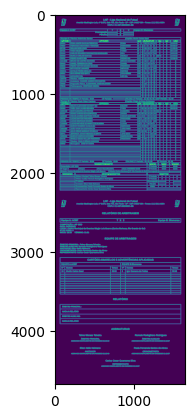

In [4]:
#Test preprocessing the images b4 OCR
def preprocess(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(gray, (5,5), 0)
    thresh = cv.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    return thresh

base_preprocessed = preprocess(base)
sumula_preprocessed = preprocess(sumula)

plt.imshow(sumula_preprocessed)


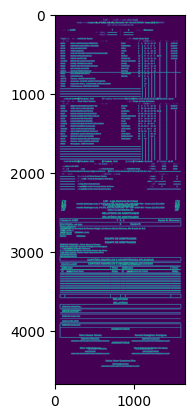

In [5]:
#test of the elimination by comparison
def eliminate_by_comparison(base, sumula):
    #find the differences between the images
    diff = cv.absdiff(base, sumula)
    #threshold the differences
    diff = cv.threshold(diff, 30, 255, cv.THRESH_BINARY)[1]
    return diff

diff = eliminate_by_comparison(base_preprocessed, sumula_preprocessed)
plt.imshow(diff)


In [6]:
# Carrega os CSVs
base_csv = pd.read_csv('images/output/BASE-LNF_combined.csv')
preenchido_csv = pd.read_csv('images/output/SUMULA1-LNF_combined.csv')

# Remove as colunas que podem ser irrelevantes para comparação (ajuste conforme necessário)
columns_to_compare = ['bbox', 'text']

# Filtra apenas as colunas relevantes para a comparação
base_filtered = base_csv[columns_to_compare]
preenchido_filtered = preenchido_csv[columns_to_compare]

# Remove as linhas da súmula preenchida que estão presentes na súmula base
filtered_preenchido_csv = preenchido_csv[~preenchido_filtered.isin(base_filtered.to_dict(orient='list')).all(axis=1)]

# Salva o resultado em um novo CSV
filtered_preenchido_csv.to_csv('sumula_preenchida_filtrada.csv', index=False)

print("Processo concluído! Arquivo 'sumula_preenchida_filtrada.csv' foi criado.")

Processo concluído! Arquivo 'sumula_preenchida_filtrada.csv' foi criado.


True

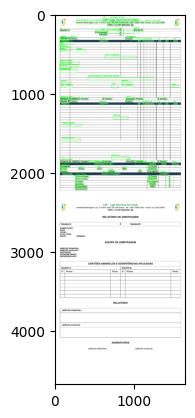

In [7]:
import ast
#use the filtered csv to annotate the remaining bboxes on the input image
def annotate_remaining_bboxes(img, csv_path):
    csv = pd.read_csv(csv_path)
    for i, row in csv.iterrows():
        bbox = ast.literal_eval(row['bbox'])  # Converte a string da bounding box em uma lista de listas
        # Extraindo os pontos superior-esquerdo (x1, y1) e inferior-direito (x2, y2)
        x1, y1 = bbox[0]
        x2, y2 = bbox[2]
        
        text = row['text']  # Nome da coluna correta é 'text'
        
        # Desenha o retângulo e o texto na imagem
        cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(img, text, (x1, y1-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return img

# Supondo que a imagem seja carregada em 'sumula'
# sumula = cv.imread('caminho_para_sua_imagem.png')

# Chame a função para anotar a imagem
annotated_img = annotate_remaining_bboxes(sumula.copy(), 'sumula_preenchida_filtrada.csv')
annotated_base = annotate_remaining_bboxes(base.copy(), 'images/output/BASE-LNF_combined.csv')

# Exibindo a imagem anotada
plt.imshow(annotated_img,cmap='gray')
cv.imwrite('LNF11_filtrada.png', annotated_img)
plt.imshow(annotated_base,cmap='gray')
cv.imwrite('LNF11_base.png', annotated_base)




In [8]:
#retrieve the mean prob from the OCR from the csv
def retrieve_mean_prob(csv_path):
    csv = pd.read_csv(csv_path)
    mean_prob = csv['prob'].mean()
    return mean_prob

mean_prob_base = retrieve_mean_prob('images/output/BASE-LNF_combined.csv')
mean_prob_preenchido = retrieve_mean_prob('images/output/SUMULA1-LNF_combined.csv')
print(f'Mean probability for base: {mean_prob_base}')
print(f'Mean probability for preenchido: {mean_prob_preenchido}')


Mean probability for base: 0.9145130848274442
Mean probability for preenchido: 0.9355399382315296
